# Motor Vehicle Crash Data:
## A Causal and Predictive Analysis
#### by Madhukar Mantravadi

In [773]:
# imports
from CHAID import Tree
from datetime import datetime
import numpy as np
import pandas as pd
pd.options.display.max_columns = 100
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from imblearn.ensemble import BalancedRandomForestClassifier
import plotly.plotly as py
import plotly.figure_factory as ff
import plotly.graph_objs as go
import plotly.io as pio
import plotly
plotly.tools.set_credentials_file(username='mmadhu94', api_key='mRx4CKJkIDFteX89rFwQ')

## EDA

*Reading the csv files into pandas dataframe form*

In [582]:
df_IncidentData = pd.read_csv('Crash_Reporting_-_Incidents_Data.csv')

In [2]:
df_DriversData = pd.read_csv('Crash_Reporting_-_Drivers_Data.csv')

/Users/madhu/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3018: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [19]:
df_DriversData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84192 entries, 0 to 84191
Data columns (total 32 columns):
Report Number                   84192 non-null object
Local Case Number               84192 non-null object
Agency Name                     84192 non-null object
ACRS Report Type                84192 non-null object
Crash Date/Time                 84192 non-null object
Route Type                      76368 non-null object
Road Name                       76728 non-null object
Cross-Street Type               76359 non-null object
Cross-Street Name               76724 non-null object
Off-Road Description            7463 non-null object
Municipality                    8587 non-null object
Related Non-Motorist            2545 non-null object
Collision Type                  83919 non-null object
Weather                         77739 non-null object
Surface Condition               74479 non-null object
Light                           83515 non-null object
Traffic Control               

In [559]:
df_IncidentData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47204 entries, 0 to 47203
Data columns (total 31 columns):
Report Number                   47204 non-null object
Local Case Number               47204 non-null object
Agency Name                     47204 non-null object
ACRS Report Type                47204 non-null object
Crash Date/Time                 47204 non-null object
Route Type                      41120 non-null object
Road Name                       41354 non-null object
Cross-Street Type               41112 non-null object
Cross-Street Name               41350 non-null object
Off-Road Description            5849 non-null object
Municipality                    4671 non-null object
Related Non-Motorist            2515 non-null object
At Fault                        47204 non-null object
Collision Type                  46976 non-null object
Weather                         43280 non-null object
Surface Condition               40117 non-null object
Light                         

*It can be seen above that there are certain features that do not contain many non-null values (i.e. Related Non-Motorists in the Driver Data, Municipality in the Non Motorist Data, and Non Motorist Substance Abuse in the Incedents Dataset). These features may not be a good choice for analysis because the data is so unbalanced.*

In [494]:
df_DriversData.head()

,Report Number,Local Case Number,Agency Name,ACRS Report Type,Crash Date/Time,Route Type,Road Name,Cross-Street Type,Cross-Street Name,Off-Road Description,Municipality,Related Non-Motorist,Collision Type,Weather,Surface Condition,Light,Traffic Control,Driver Substance Abuse,Non-Motorist Substance Abuse,Person ID,Driver At Fault,Injury Severity,Circumstance,Driver Distracted By,Drivers License State,Vehicle ID,Vehicle Damage Extent,Vehicle Body Type,Vehicle Movement,Latitude,Longitude,Location
0,MCP2077000Z,15063285,Montgomery County Police,Property Damage Crash,2015-12-11 07:39:00,County,RANDOLPH RD,Maryland (State),VEIRS MILL RD,NaN,NaN,NaN,SAME DIR REAR END,NaN,DRY,DAYLIGHT,NaN,NONE DETECTED,NaN,A6C3B9B2-57F6-48A0-9112-110EEC2DB8BF,Yes,NO APPARENT INJURY,NaN,UNKNOWN,MD,EF3ABA0A-5BC0-48C5-A753-A92679EA0069,SUPERFICIAL,PASSENGER CAR,SLOWING OR STOPPING,39.057507,-77.079070,"(39.057507, -77.07907)"
1,MCP2723001N,16027050,Montgomery County Police,Property Damage Crash,2016-05-31 11:03:00,Maryland (State),GEORGIA AVE,County,EMORY LA,NaN,NaN,NaN,SAME DIR REAR END,CLEAR,DRY,DAYLIGHT,TRAFFIC SIGNAL,NaN,NaN,9A45DABB-A577-4F9F-BB57-CFE5E352AE40,No,NO APPARENT INJURY,NaN,NOT DISTRACTED,MD,1C743E0D-1F93-48BF-A6F4-17005EF41460,DISABLING,PASSENGER CAR,STOPPED IN TRAFFIC LANE,39.126190,-77.072305,"(39.12619016, -77.07230508)"
2,MCP2549004Z,16032508,Montgomery County Police,Property Damage Crash,2016-06-27 12:28:00,Maryland (State),WISCONSIN AVE,County,WISCONSIN CIR,NaN,NaN,NaN,SAME DIRECTION SIDESWIPE,CLEAR,DRY,DAYLIGHT,NaN,NONE DETECTED,NaN,8EDAC67D-D729-4113-98C4-5303C3839353,Yes,NO APPARENT INJURY,NaN,DISTRACTED BY OUTSIDE PERSON OBJECT OR EVENT,DC,7CA91E41-EBFC-4535-9B33-5420F2B25822,SUPERFICIAL,PASSENGER CAR,MOVING CONSTANT SPEED,38.961752,-77.086057,"(38.96175167, -77.08605667)"
3,MCP2954001Y,16032884,Montgomery County Police,Injury Crash,2016-06-29 12:48:00,County,CHERRY HILL RD,County,PLUM ORCHARD DR,NaN,NaN,NaN,STRAIGHT MOVEMENT ANGLE,CLEAR,DRY,DAYLIGHT,NO CONTROLS,NONE DETECTED,NaN,BAA52CC0-4209-402C-9436-BA8A15A1F71B,Yes,NO APPARENT INJURY,NaN,LOOKED BUT DID NOT SEE,MD,C268EF3B-5FE4-45CA-B73B-3DC2ADF94582,SUPERFICIAL,PASSENGER CAR,MAKING LEFT TURN,39.048794,-76.952341,"(39.04879391, -76.9523406)"
4,DD5614000T,16032242,Rockville Police Departme,Property Damage Crash,2016-06-25 20:40:00,Maryland (State),ROCKVILLE PIKE,Unknown,CROSSOVER,NaN,NaN,NaN,SAME DIR REAR END,CLEAR,DRY,DUSK,NO CONTROLS,NONE DETECTED,NaN,181C0680-2A4F-486A-94BA-35D88C05E2E2,No,NO APPARENT INJURY,NaN,NOT DISTRACTED,MD,6A3719C1-B85E-4913-933D-6CC126CF42CD,FUNCTIONAL,PASSENGER CAR,SLOWING OR STOPPING,39.067520,-77.128667,"(39.06752, -77.12866667)"


In [621]:
df_IncidentData.head()

,Report Number,Local Case Number,Agency Name,ACRS Report Type,Crash Date/Time,Route Type,Road Name,Cross-Street Type,Cross-Street Name,Off-Road Description,Municipality,Related Non-Motorist,At Fault,Collision Type,Weather,Surface Condition,Light,Traffic Control,Driver Substance Abuse,Non-Motorist Substance Abuse,First Harmful Event,Second Harmful Event,Fixed Oject Struck,Junction,Intersection Type,Road Alignment,Road Condition,Road Division,Latitude,Longitude,Location,Second Event Existing,latbin,lonbin,Hour
0,MCP26890028,16046213,Montgomery County Police,Property Damage Crash,2016-09-09 13:53:00,County,E JEFFERSON ST,Unknown,CALIFORNIA CIR,NaN,NaN,NaN,DRIVER,SAME DIR REAR END,CLEAR,DRY,DAYLIGHT,NO CONTROLS,NONE DETECTED,NaN,OTHER VEHICLE,NO 2ND EVENT,NaN,NON INTERSECTION,NaN,STRAIGHT,NO DEFECTS,"TWO-WAY, NOT DIVIDED WITH A CONTINUOUS LEFT TURN",39.056853,-77.126215,"(39.05685333, -77.126215)",0,39.042857,-77.128571,13
1,MCP11520005,15000008,Montgomery County Police,Property Damage Crash,2015-01-01 00:30:00,Maryland (State),ROCKVILLE PIKE,County,GROSVENOR LA,NaN,NaN,NaN,DRIVER,SAME DIR REAR END,CLEAR,DRY,DARK LIGHTS ON,TRAFFIC SIGNAL,"ALCOHOL CONTRIBUTED, N/A",NaN,OTHER VEHICLE,NO 2ND EVENT,NaN,INTERSECTION RELATED,FOUR-WAY INTERSECTION,STRAIGHT,NO DEFECTS,"TWO-WAY, DIVIDED, POSITIVE MEDIAN BARRIER",39.022001,-77.102673,"(39.02200107, -77.10267305)",0,39.014286,-77.114286,0
2,MCP2916001N,170521681,Montgomery County Police,Property Damage Crash,2017-07-28 14:00:00,NaN,NaN,NaN,NaN,14620 PALMER HOUSE WAY,NaN,NaN,DRIVER,OTHER,RAINING,NaN,DAYLIGHT,NO CONTROLS,NONE DETECTED,NaN,OTHER VEHICLE,NO 2ND EVENT,NaN,NaN,NaN,NaN,NaN,NaN,39.051213,-76.988397,"(39.05121333, -76.98839667)",0,39.042857,-77.000000,14
3,DD56040016,15051858,ROCKVILLE,Property Damage Crash,2015-10-12 23:59:00,Municipality,EDMONSTON DR,Municipality,CRAWFORD DR,NaN,ROCKVILLE,NaN,DRIVER,OPPOSITE DIRECTION SIDESWIPE,CLEAR,DRY,DARK LIGHTS ON,NO CONTROLS,NONE DETECTED,NaN,PARKED VEHICLE,NO 2ND EVENT,NaN,NON INTERSECTION,NaN,CURVE LEFT,NO DEFECTS,"TWO-WAY, DIVIDED, UNPROTECTED PAINTED MIN 4 FEET",39.077498,-77.130993,"(39.07749833, -77.13099333)",0,39.071429,-77.142857,23
4,MCP1502000L,15058824,MONTGOMERY,Injury Crash,2015-11-18 05:54:00,County,SNOUFFERS SCHOOL RD,County,GOSHEN RD,NaN,NaN,NaN,DRIVER,STRAIGHT MOVEMENT ANGLE,CLEAR,DRY,DARK NO LIGHTS,STOP SIGN,NONE DETECTED,NaN,OTHER VEHICLE,NO 2ND EVENT,NaN,INTERSECTION,T-INTERSECTION,STRAIGHT,NO DEFECTS,"TWO-WAY, NOT DIVIDED",39.161005,-77.163395,"(39.161005, -77.163395)",0,39.157143,-77.171429,5


In [608]:
'''I chose the step here to bin the lat/long by such that 
it will divide the area that the accidents took place into 1 sq mi incriments'''

step = 1/70
to_bin = lambda x: np.floor(x / step) * step
df_IncidentData["latbin"] = df_IncidentData.Latitude.map(to_bin)
df_IncidentData["lonbin"] = df_IncidentData.Longitude.map(to_bin)

In [585]:
#Cleaning up the dataframe columns that are relevant
df_DriversData['Injury Severity'] = df_DriversData['Injury Severity'].str.replace('INJURY','')
df_IncidentData['Second Harmful Event'] = df_IncidentData['Second Harmful Event'].replace(np.NaN,'NO 2ND EVENT')

In [620]:
#Engineering new features to utilize time and 'Second Harmful Event' data
df_IncidentData['Second Event Existing'] = [0 if i == 'NO 2ND EVENT' else 1 
                                            for i in df_IncidentData['Second Harmful Event']]
df_IncidentData['Hour'] = df_IncidentData['Crash Date/Time'].dt.hour

In [639]:
#Generating dummy column features based on the types of harmful events in the 'First Harmful Event' feature
df_IncDummy = pd.concat([df_IncidentData.copy(),
                         pd.get_dummies(df_IncidentData['First Harmful Event'],prefix = 'Harm')], axis = 1)

In [643]:
#Dropping the original column for redundancy
df_IncDummy.drop('First Harmful Event', axis=1, inplace = True)

In [644]:
df_IncDummy

,Report Number,Local Case Number,Agency Name,ACRS Report Type,Crash Date/Time,Route Type,Road Name,Cross-Street Type,Cross-Street Name,Off-Road Description,Municipality,Related Non-Motorist,At Fault,Collision Type,Weather,Surface Condition,Light,Traffic Control,Driver Substance Abuse,Non-Motorist Substance Abuse,Second Harmful Event,Fixed Oject Struck,Junction,Intersection Type,Road Alignment,Road Condition,Road Division,Latitude,Longitude,Location,Second Event Existing,latbin,lonbin,Hour,Harm_ANIMAL,Harm_BACKING,Harm_BICYCLE,Harm_DOWNHILL RUNAWAY,Harm_EXPLOSION OR FIRE,Harm_FELL JUMPED FROM MOTOR VEHICLE,Harm_FIXED OBJECT,Harm_IMMERSION,Harm_JACKKNIFE,Harm_OFF ROAD,Harm_OTHER,Harm_OTHER CONVEYANCE,Harm_OTHER NON COLLISION,Harm_OTHER OBJECT,Harm_OTHER PEDALCYCLE,Harm_OTHER VEHICLE,Harm_OVERTURN,Harm_PARKED VEHICLE,Harm_PEDESTRIAN,Harm_RAILWAY TRAIN,Harm_SPILLED CARGO,Harm_THROWN OR FALLING OBJECT,Harm_U-TURN,Harm_UNITS SEPARATED,Harm_UNKNOWN
0,MCP26890028,16046213,Montgomery County Police,Property Damage Crash,2016-09-09 13:53:00,County,E JEFFERSON ST,Unknown,CALIFORNIA CIR,NaN,NaN,NaN,DRIVER,SAME DIR REAR END,CLEAR,DRY,DAYLIGHT,NO CONTROLS,NONE DETECTED,NaN,NO 2ND EVENT,NaN,NON INTERSECTION,NaN,STRAIGHT,NO DEFECTS,"TWO-WAY, NOT DIVIDED WITH A CONTINUOUS LEFT TURN",39.056853,-77.126215,"(39.05685333, -77.126215)",0,39.042857,-77.128571,13,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
1,MCP11520005,15000008,Montgomery County Police,Property Damage Crash,2015-01-01 00:30:00,Maryland (State),ROCKVILLE PIKE,County,GROSVENOR LA,NaN,NaN,NaN,DRIVER,SAME DIR REAR END,CLEAR,DRY,DARK LIGHTS ON,TRAFFIC SIGNAL,"ALCOHOL CONTRIBUTED, N/A",NaN,NO 2ND EVENT,NaN,INTERSECTION RELATED,FOUR-WAY INTERSECTION,STRAIGHT,NO DEFECTS,"TWO-WAY, DIVIDED, POSITIVE MEDIAN BARRIER",39.022001,-77.102673,"(39.02200107, -77.10267305)",0,39.014286,-77.114286,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2,MCP2916001N,170521681,Montgomery County Police,Property Damage Crash,2017-07-28 14:00:00,NaN,NaN,NaN,NaN,14620 PALMER HOUSE WAY,NaN,NaN,DRIVER,OTHER,RAINING,NaN,DAYLIGHT,NO CONTROLS,NONE DETECTED,NaN,NO 2ND EVENT,NaN,NaN,NaN,NaN,NaN,NaN,39.051213,-76.988397,"(39.05121333, -76.98839667)",0,39.042857,-77.000000,14,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
3,DD56040016,15051858,ROCKVILLE,Property Damage Crash,2015-10-12 23:59:00,Municipality,EDMONSTON DR,Municipality,CRAWFORD DR,NaN,ROCKVILLE,NaN,DRIVER,OPPOSITE DIRECTION SIDESWIPE,CLEAR,DRY,DARK LIGHTS ON,NO CONTROLS,NONE DETECTED,NaN,NO 2ND EVENT,NaN,NON INTERSECTION,NaN,CURVE LEFT,NO DEFECTS,"TWO-WAY, DIVIDED, UNPROTECTED PAINTED MIN 4 FEET",39.077498,-77.130993,"(39.07749833, -77.13099333)",0,39.071429,-77.142857,23,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
4,MCP1502000L,15058824,MONTGOMERY,Injury Crash,2015-11-18 05:54:00,County,SNOUFFERS SCHOOL RD,County,GOSHEN RD,NaN,NaN,NaN,DRIVER,STRAIGHT MOVEMENT ANGLE,CLEAR,DRY,DARK NO LIGHTS,STOP SIGN,NONE DETECTED,NaN,NO 2ND EVENT,NaN,INTERSECTION,T-INTERSECTION,STRAIGHT,NO DEFECTS,"TWO-WAY, NOT DIVIDED",39.161005,-77.163395,"(39.161005, -77.163395)",0,39.157143,-77.171429,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
5,EJ7858000C,15052805,GAITHERSBURG,Property Damage Crash,2015-10-18 23:45:00,Maryland (State),MONTGOMERY VILLAGE AVE,Maryland (State),FREDERICK RD,NaN,NaN,NaN,DRIVER,SAME DIRECTION LEFT TURN,CLEAR,DRY,DARK LIGHTS ON,NO CONTROLS,"NONE DETECTED, UNKNOWN",NaN,NO 2ND EVENT,NaN,NaN,FOUR-WAY INTERSECTION,STRAIGHT,NO DEFECTS,"TWO-WAY, DIVIDED, POSITIVE MEDIAN BARRIER",39.152769,-77.211592,"(39.15276875, -77.2115922)",0,39.142857,-77.214286,23,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
6,MCP29190038,170520140,Montgomery County Police,Property Damage Crash,2017-07-20 11:10:00,County,SLIGO AVE,County,FENTON ST,NaN,NaN,NaN,DRIVER,ANGLE MEETS LEFT TURN,CLEAR,DRY,DAYLIGHT,NaN,NONE DETECTED,NaN,NO 2ND EVENT,NaN,COMMERCIAL DRIVEWAY,NaN,STRAIGHT,NO DEFECTS,"TWO-WAY, NOT DIVIDED",38.990122,-77.022377,"(38.99012167, -77.02237667)",0,

*Converting the date/time data to datetime form*

In [419]:
#Making a function to convert to datetime utilizing the apply method on a pandas dataframe
def timestripper(string):
    return datetime.strptime(string, '%m/%d/%Y %I:%M:%S %p')

In [614]:
df_DriversData['Crash Date/Time'] = df_DriversData['Crash Date/Time'].apply(timestripper)

In [615]:
df_IncidentData['Crash Date/Time'] = df_IncidentData['Crash Date/Time'].apply(timestripper)

*The following is code for several plots looking at frequency of accidents anddifferent incriments of time*

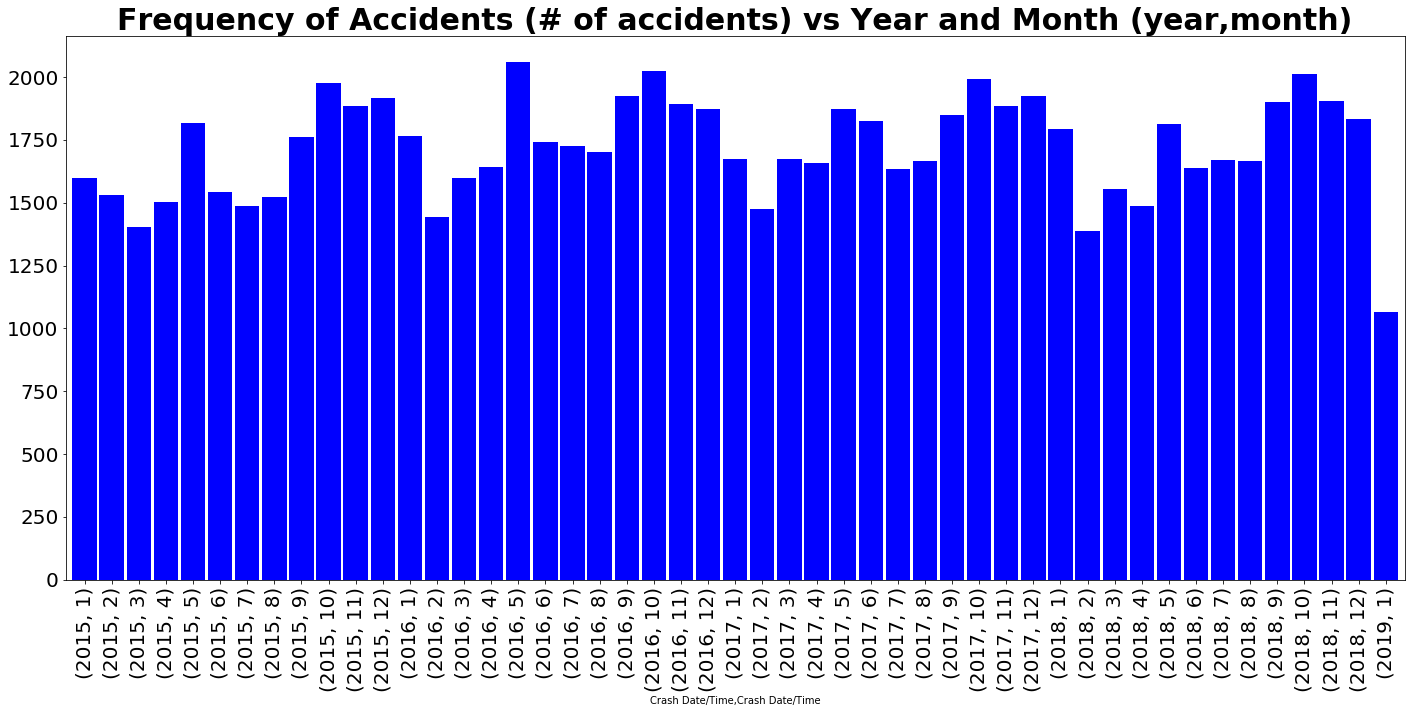

In [550]:
plt.title('Frequency of Accidents (# of accidents) vs Year and Month (year,month)',fontdict={'fontsize': 30,
        'fontweight' : 'bold'})
df_DriversData['Crash Date/Time'].groupby([df_DriversData['Crash Date/Time'].dt.year, 
                                           df_DriversData['Crash Date/Time'].dt.month]).count().plot(figsize = (24,10), 
                                                                                                     fontsize = 20, kind="bar", 
                                                                                                     width = 0.9, color = 'blue')
plt.savefig('FreqVsYrMnth.png')

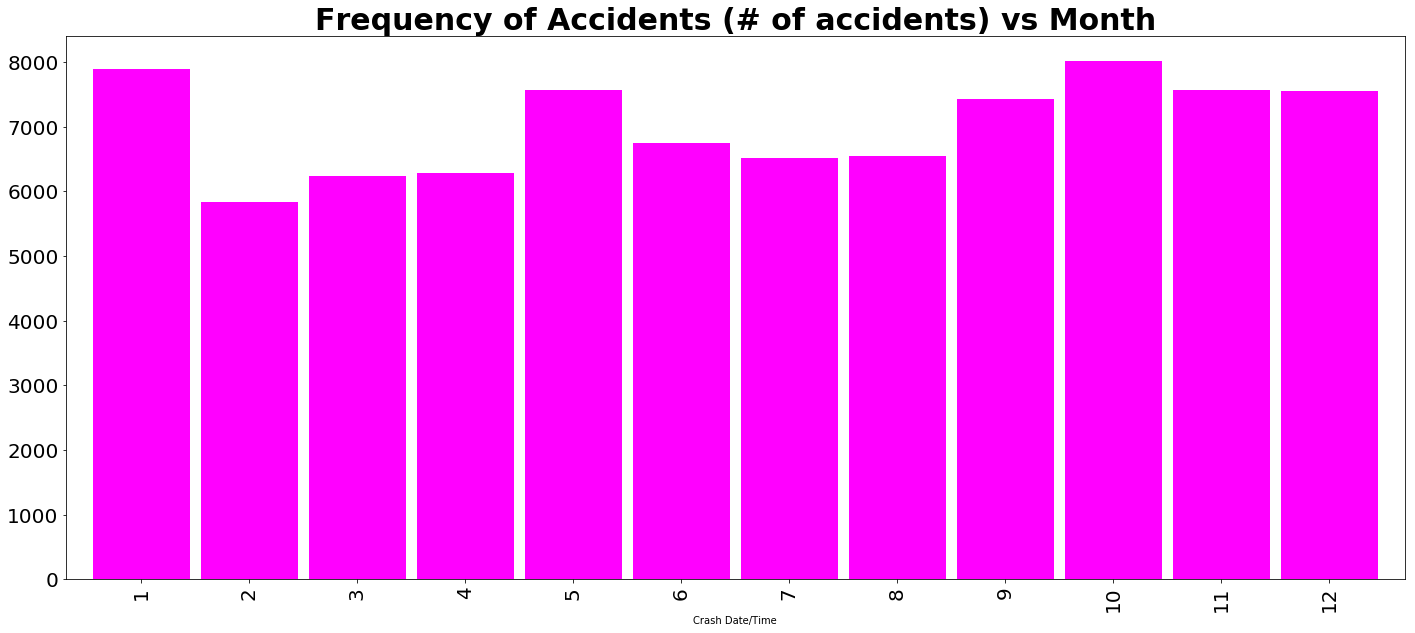

In [551]:
plt.title('Frequency of Accidents (# of accidents) vs Month',fontdict={'fontsize': 30,
        'fontweight' : 'bold'})
df_DriversData['Crash Date/Time'].groupby([df_DriversData['Crash Date/Time'].dt.month]).count().plot(figsize = (24,10), 
                                                                                                     fontsize = 20, kind="bar", 
                                                                                                     width = 0.9, color = 'magenta')
plt.savefig('FreqVsMnth.png')

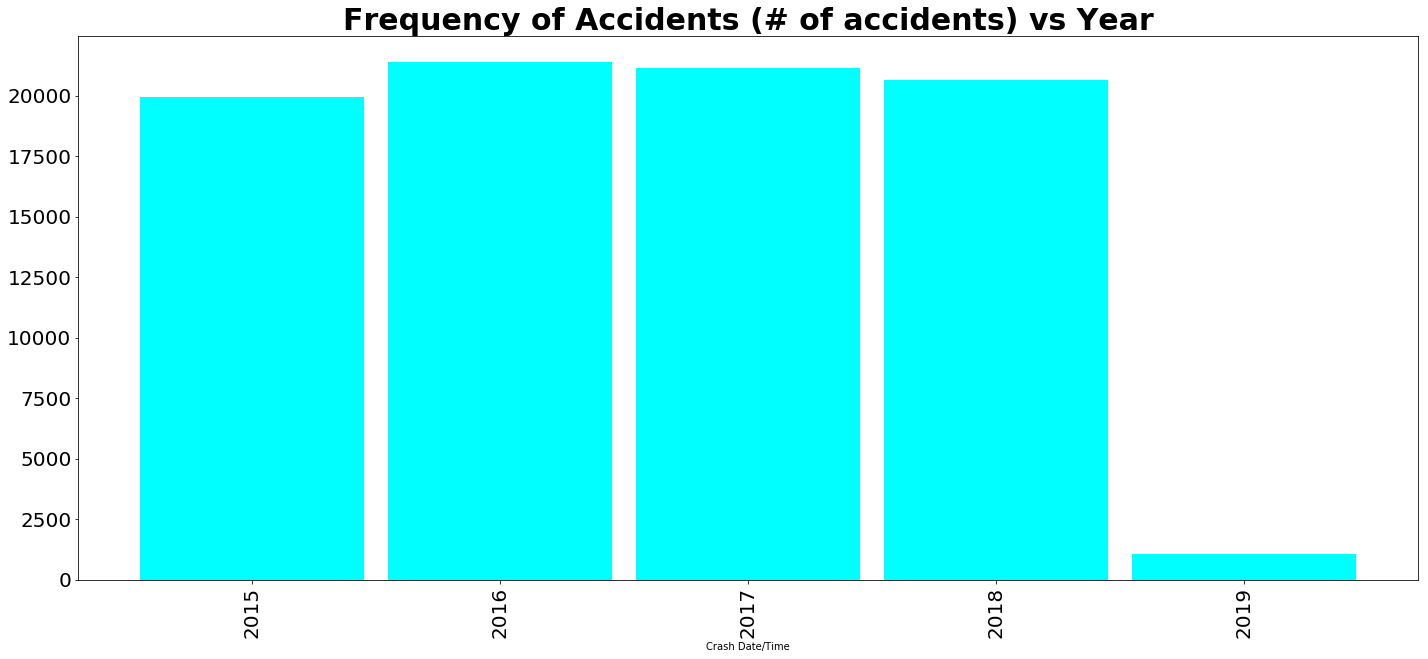

In [552]:
plt.title('Frequency of Accidents (# of accidents) vs Year',fontdict={'fontsize': 30,
        'fontweight' : 'bold'})
df_DriversData['Crash Date/Time'].groupby([df_DriversData['Crash Date/Time'].dt.year]).count().plot(figsize = (24,10), 
                                                                                                     fontsize = 20, kind="bar", 
                                                                                                     width = 0.9, color = 'cyan')
plt.savefig('FreqVsYr.png')

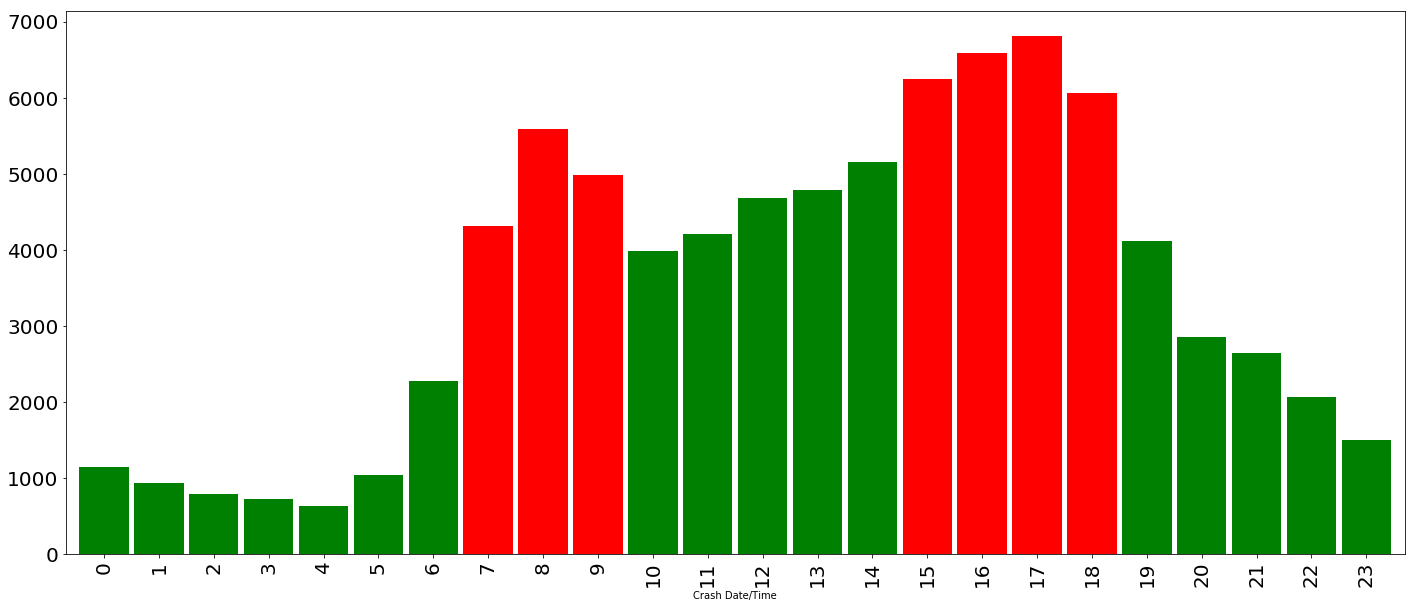

In [553]:
df_DriversData['Crash Date/Time'].groupby([df_DriversData['Crash Date/Time'].dt.hour]).count().plot(figsize = (24,10), 
                                                                                                     fontsize = 20, kind="bar", 
                                                                                                     width = 0.9, color = ['g' if i not in (7,8,9,15,16,17,18) else 'r' for i in range(24)])
plt.savefig('FreqVsHr.png')

In the lots above looking at the datetime information we can tell a few things:
 - Looking at the year and month plot, there seems to be some cyclical nature to the frequency of accidents, with the later months of the year (OCT-DEC) seem to have a higher frequency of accidents.
 - Looking at the month plot and year plot as seperated data, however doesn't show much of a correlation. For the year especially it seems to be almost equal for every year except 2019, which is only small because we are currrently in the 1st month of the year only.
 - The hour plot shows something that with knowledge of work culture makes sense; The peak accident times are from 7-9 am and 3-6 pm. This makes sense since those are the times of most peoples work commutes and when there is usually more traffic. 

*Plotly code for interactive 2d histograms of Hr vs Injury Severity and Hr vs Vehicle Damage Extent*

In [543]:
layout = go.Layout(margin = dict(b = 50, l = 50), 
                   yaxis = dict(
                                title='Injury Severity',
                                tickmode='array',
                                automargin=True,
                                titlefont=dict(size=20)
                                ),
                   xaxis = dict(
                                title = 'Hour of Day (24h)',
                                tickvals = list(range(24)),
                                titlefont=dict(size=20)
                                ))

In [834]:
x = df_DriversData['Crash Date/Time'].dt.hour
y = df_DriversData['Injury Severity']
trace = [go.Histogram2dContour(
        x = x,
        y = y,
        colorscale = 'Viridis',
        contours = dict(
            showlabels = True,
            labelfont = dict(
                family = 'Raleway',
                color = 'white'
            )
        ),
        hoverlabel = dict(
            bgcolor = 'white',
            bordercolor = 'black',
            font = dict(
                family = 'Raleway',
                color = 'black'
            )
        )
)]

fig = go.Figure(data = trace, layout = layout)
py.iplot(fig, filename = "Histogram2d_Crash_Injury")

/Users/madhu/anaconda3/lib/python3.6/site-packages/plotly/plotly/plotly.py:230: UserWarning:

Woah there! Look at all those points! Due to browser limitations, the Plotly SVG drawing functions have a hard time graphing more than 500k data points for line charts, or 40k points for other types of charts. Here are some suggestions:
(1) Use the `plotly.graph_objs.Scattergl` trace object to generate a WebGl graph.
(2) Trying using the image API to return an image instead of a graph URL
(3) Use matplotlib
(4) See if you can create your visualization with fewer data points

If the visualization you're using aggregates points (e.g., box plot, histogram, etc.) you can disregard this warning.



*From the plot generated above it can be seen that most accidents fall within either the "Possible Injury" or "No Apparent Injury". Looking at the trend within the more serious injuries, there are small increases there during rush hour times as well. However, the sample size of those types of injuries are much smaller and thus there is not really enough evidence to definitively say that rush hours result in higher amounts of severe crashes.* 

In [556]:
layout = go.Layout(margin = dict(b = 50, l = 50), 
                   yaxis = dict(
                                title='Vehicle Damage Extent',
                                tickmode='array',
                                automargin=True,
                                titlefont=dict(size=20)
                                ),
                   xaxis = dict(
                                title = 'Hour of Day (24h)',
                                tickvals = list(range(24)),
                                titlefont=dict(size=20)
                                ))

In [835]:
x = df_DriversData['Crash Date/Time'].dt.hour
y = df_DriversData['Vehicle Damage Extent']
trace = [go.Histogram2dContour(
        x = x,
        y = y,
        colorscale = 'Viridis',
        contours = dict(
            showlabels = True,
            labelfont = dict(
                family = 'Raleway',
                color = 'white'
            )
        ),
        hoverlabel = dict(
            bgcolor = 'white',
            bordercolor = 'black',
            font = dict(
                family = 'Raleway',
                color = 'black'
            )
        )
)]

fig = go.Figure(data = trace, layout = layout)
py.iplot(fig, filename = "Histogram2d_Crash_Damage")

*It can be seen above that most crashes result in either "Disabling", "Superficial", or "Functional" extent to the damage. It is even clearer here that there are more crashes overall during rush hour commute times. There is a large spike in the "No Damage" category during rush hour times as well.*

**The code above can be run for interactive 2d histograms. A static image of the plots is available in the report accompanying this code.**

*It could be said with more certainty, however that more crashes happen during rush hour. I will continue to look at the effects of different features, namely whether it's Light or Dark outside and how that change causes change within the severity of crashes.*

In [573]:
#Looking at the amounts of unique values in each dataframe
df_DriversData.nunique().sort_values()

Driver At Fault                     3
ACRS Report Type                    3
Injury Severity                     5
Vehicle Damage Extent               7
Light                               8
Agency Name                         8
Non-Motorist Substance Abuse        9
Route Type                         10
Cross-Street Type                  10
Related Non-Motorist               10
Driver Substance Abuse             11
Traffic Control                    11
Surface Condition                  11
Weather                            12
Collision Type                     18
Driver Distracted By               19
Municipality                       20
Vehicle Movement                   22
Vehicle Body Type                  30
Drivers License State              71
Circumstance                      145
Road Name                        2537
Cross-Street Name                4995
Off-Road Description             5508
Latitude                        42015
Longitude                       42847
Crash Date/T

In [572]:
df_IncidentData.nunique().sort_values()

ACRS Report Type                    3
At Fault                            4
Road Alignment                      5
Road Division                       7
Agency Name                         8
Intersection Type                   8
Light                               8
Route Type                         10
Non-Motorist Substance Abuse       10
Cross-Street Type                  10
Road Condition                     10
Traffic Control                    11
Surface Condition                  11
Related Non-Motorist               11
Weather                            12
Junction                           12
Collision Type                     18
Municipality                       20
Second Harmful Event               24
First Harmful Event                25
Fixed Oject Struck                 25
Driver Substance Abuse             45
Road Name                        2563
Cross-Street Name                5012
Off-Road Description             5656
Latitude                        42269
Longitude   

*Using a feature with too many categories/distinct values may not be good for a causal analysis as well because there are too many different factors in that kind of analysis. It is possible, but for the purpose of this analysis the focus will be placed on the top few features in the above series (which have the lowest count of unique values/observations)*

## Causal Hypothesis and Testing

### Looking at the data the more specific/detailed features such as location and street name have *far* more categories than some of the other more general ones such as wheather the driver is at fault for the accident or not. Because of the amount of unique values, I decided to look into the effect of time of day via the 'Light' feature on Injury Severity and Vehicle Damage Extent

### Hypothesis: The light will effect the Injury Severity and Vehicle Damage Extent and that the darker it is, the higher the ratio of severe damage to temperate damage.

 $H_o =$ **The light (time of day) doesn't have a relationship with the Injury Severity and Vehicle Damage Extent** 
 <br>
 $H_1 =$ **The light (time of day) *does* have a relationship with the Injury Severity and Vehicle Damage Extent**

*To do this experiment, first I will conduct a $\chi^2$ test to determine which hypothesis we will reject. This will not find the actual relationship but provide evidence that there is grounds for one.*

In [333]:
light_drops = list(df_DriversData['Light'].value_counts().index[-5:])

In [334]:
vehicle_damage_drops = list(df_DriversData['Vehicle Damage Extent'].value_counts().index[-2:])

*Below we are defining the dataframe we are going to use and cleaning up a bit. I decided to remove some of the smaller categories in the data that had magnitudes smaller in their value counts.
<br>
I created masks to filter the datafram based on the values I wanted to cut and then also dropped rows with NaN.*

In [366]:
df_CHAID = df_DriversData[['Injury Severity','Vehicle Damage Extent', 'Light']]
df_CHAID.dropna(inplace = True)

mask_light = df_CHAID[df_CHAID['Light'].isin(light_drops)].index
mask_light = list(mask_light)
df_CHAID.drop(mask_light, inplace=True)

mask_vdamage = df_CHAID[df_CHAID['Vehicle Damage Extent'].isin(vehicle_damage_drops)].index
mask_vdamage = list(mask_vdamage)
df_CHAID.drop(mask_vdamage, inplace = True)

/Users/madhu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/Users/madhu/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


***Here I'm using the CHAID (Chi-squared Automatic Interaction Detector) algorithm to do the test. I am using an existing library called CHAID that allows me to generate the values easily.***

 - The CHAID Algorithm checks the statistical significance via the $\chi^2$ test and outputs the counts of all categories within each of the features of the variable. It does this for every variable and generates every crosstab it can that has statistical significance. 
 
 - If a feature is shown to not be significant, it will try to combine it with another non-significant feature and run the test again. This can lead to misleading or useless results for certain features. In the following analysis I have taken steps to try and avoid this but it is something to be weary of. One should not just follow a model's results blindly.

In [348]:
#defining Variables to use in the CHAID function
indep_var = ['Light']
dep_var1 = 'Injury Severity'
dep_var2 = 'Vehicle Damage Extent'

#Building the tree
tree1 = Tree.from_pandas_df(df_CHAID, dict(zip(indep_var, ['nominal'] * 3)), dep_var1, max_depth=1)
tree2 = Tree.from_pandas_df(df_CHAID, dict(zip(indep_var, ['nominal'] * 3)), dep_var2, max_depth=1)

In [368]:
#Converting the tree to an object to view it
tree1.to_tree()
tree2.to_tree()

In [350]:
#Printing out the different trees to see the results in raw form
tree1.print_tree()

([], {'FATAL INJURY': 52.0, 'NO APPARENT INJURY': 60917.0, 'POSSIBLE INJURY': 8011.0, 'SUSPECTED MINOR INJURY': 6193.0, 'SUSPECTED SERIOUS INJURY': 684.0}, (Light, p=8.839978512287383e-08, score=48.25248248399449, groups=[['DARK LIGHTS ON'], ['DARK NO LIGHTS'], ['DAYLIGHT']]), dof=8))
|-- (['DARK LIGHTS ON'], {'FATAL INJURY': 17.0, 'NO APPARENT INJURY': 14265.0, 'POSSIBLE INJURY': 1778.0, 'SUSPECTED MINOR INJURY': 1492.0, 'SUSPECTED SERIOUS INJURY': 159.0}, <Invalid Chaid Split> - the max depth has been reached)
|-- (['DARK NO LIGHTS'], {'FATAL INJURY': 8.0, 'NO APPARENT INJURY': 1948.0, 'POSSIBLE INJURY': 245.0, 'SUSPECTED MINOR INJURY': 237.0, 'SUSPECTED SERIOUS INJURY': 29.0}, <Invalid Chaid Split> - the max depth has been reached)
+-- (['DAYLIGHT'], {'FATAL INJURY': 27.0, 'NO APPARENT INJURY': 44704.0, 'POSSIBLE INJURY': 5988.0, 'SUSPECTED MINOR INJURY': 4464.0, 'SUSPECTED SERIOUS INJURY': 496.0}, <Invalid Chaid Split> - the max depth has been reached)



In [351]:
tree2.print_tree()

([], {'DESTROYED': 3014.0, 'DISABLING': 28072.0, 'FUNCTIONAL': 21454.0, 'NO DAMAGE': 2972.0, 'SUPERFICIAL': 20345.0}, (Light, p=1.4650986078368781e-171, score=819.2428031650275, groups=[['DARK LIGHTS ON'], ['DARK NO LIGHTS'], ['DAYLIGHT']]), dof=8))
|-- (['DARK LIGHTS ON'], {'DESTROYED': 1050.0, 'DISABLING': 7143.0, 'FUNCTIONAL': 4517.0, 'NO DAMAGE': 584.0, 'SUPERFICIAL': 4417.0}, <Invalid Chaid Split> - the max depth has been reached)
|-- (['DARK NO LIGHTS'], {'DESTROYED': 255.0, 'DISABLING': 1035.0, 'FUNCTIONAL': 562.0, 'NO DAMAGE': 83.0, 'SUPERFICIAL': 532.0}, <Invalid Chaid Split> - the max depth has been reached)
+-- (['DAYLIGHT'], {'DESTROYED': 1709.0, 'DISABLING': 19894.0, 'FUNCTIONAL': 16375.0, 'NO DAMAGE': 2305.0, 'SUPERFICIAL': 15396.0}, <Invalid Chaid Split> - the max depth has been reached)



The **p-value** for *Injury Severity* $= \mathbf{8.8399e-08}$
<br>
The **p-value** for *Vehicle Damage Extent* $= \mathbf{1.4651e-171}$
<br>
Both of these values are $\mathbf{<0.05 \therefore}$ statistically significant.

*As we can see above both of the cases have a **p value < 0.05** and are therefore statistically significant. We can also see this by the fact that the $\chi$ score is relatively far from 0 (especially in the case of vehicle damage).* 

*We are part way into proving our hypothesis true or false but within the context of our $\chi^2$ test, we can reject the null hypothesis and accept the alternate hypothesis that the Light (time of day) has a relationship with Vehicle Damage Extent and Injury Severity.*

*Below I have calculated the ratio of worse categories to more temperate ones. I assumed that for Injury that "Fatal Injury" and "Suspected Serious Injury" were the worst case categories. For Vehicle Damage Extent, I assumed "Destroyed" and "Disabling" were the worst case.
The ratio's below are a simple calculation showing that our original hypothesis has grounds to be correct based on the data. However, correlation is not causation, so we cannot assume that this proves our causal hypothesis.*

In [359]:
#The ratios are the # of worst-case to # of other cases
dark_injury_ratio = (10+181)/(16525+1987+1692)

In [361]:
daylight_injury_ratio = (13+490)/(45478+5898+4410)

In [362]:
dark_ratio/daylight_ratio

1.0484633281286344

This ratio shows a ~5% higher amount of severe injury during the dark than the daylight.

In [363]:
dark_vdamage_ratio = (255+1050+1050+7143)/(562+83+532+4517+584+4417)

In [364]:
daylight_vdamage_ratio = (1709+19894)/(16375+2305+15396)

In [365]:
dark_vdamage_ratio/daylight_vdamage_ratio

1.400831568572725

This ratio shows ~40% more severe damage cases in the dark than during the daylight.

---

---

## Predictive Hypothesis and Testing

### Hypothesis:
#### For a predictive hypothesis and model, an analysis of the time data, location, First Harmful Event, and Second Harmful Event. 


#### Can the existence of a 2nd harmful event be predicted based on the 1st Event, the time, and the location?

*For this problem I chose multiple models to see which method will work better. The specific models were chosen because they can deal with unbalanced data and also have penalties in place so they can try to avoid falling to either end of the bias-variance spectrum.*

In [829]:
df_IncidentData['First Harmful Event'].value_counts()

OTHER VEHICLE                     32518
FIXED OBJECT                       5716
PARKED VEHICLE                     4500
PEDESTRIAN                         1807
OFF ROAD                            520
ANIMAL                              471
BICYCLE                             434
OTHER OBJECT                        339
OTHER                               151
OVERTURN                            130
UNKNOWN                              79
BACKING                              66
OTHER NON COLLISION                  61
OTHER CONVEYANCE                     40
OTHER PEDALCYCLE                     25
THROWN OR FALLING OBJECT             23
FELL JUMPED FROM MOTOR VEHICLE       18
DOWNHILL RUNAWAY                     14
SPILLED CARGO                        12
JACKKNIFE                             7
U-TURN                                5
EXPLOSION OR FIRE                     5
RAILWAY TRAIN                         5
UNITS SEPARATED                       3
IMMERSION                             1


In [709]:
df_IncDummy

,Report Number,Local Case Number,Agency Name,ACRS Report Type,Crash Date/Time,Route Type,Road Name,Cross-Street Type,Cross-Street Name,Off-Road Description,Municipality,Related Non-Motorist,At Fault,Collision Type,Weather,Surface Condition,Light,Traffic Control,Driver Substance Abuse,Non-Motorist Substance Abuse,Second Harmful Event,Fixed Oject Struck,Junction,Intersection Type,Road Alignment,Road Condition,Road Division,Latitude,Longitude,Location,Second Event Existing,latbin,lonbin,Hour,Harm_ANIMAL,Harm_BACKING,Harm_BICYCLE,Harm_DOWNHILL RUNAWAY,Harm_EXPLOSION OR FIRE,Harm_FELL JUMPED FROM MOTOR VEHICLE,Harm_FIXED OBJECT,Harm_IMMERSION,Harm_JACKKNIFE,Harm_OFF ROAD,Harm_OTHER,Harm_OTHER CONVEYANCE,Harm_OTHER NON COLLISION,Harm_OTHER OBJECT,Harm_OTHER PEDALCYCLE,Harm_OTHER VEHICLE,Harm_OVERTURN,Harm_PARKED VEHICLE,Harm_PEDESTRIAN,Harm_RAILWAY TRAIN,Harm_SPILLED CARGO,Harm_THROWN OR FALLING OBJECT,Harm_U-TURN,Harm_UNITS SEPARATED,Harm_UNKNOWN
0,MCP26890028,16046213,Montgomery County Police,Property Damage Crash,2016-09-09 13:53:00,County,E JEFFERSON ST,Unknown,CALIFORNIA CIR,NaN,NaN,NaN,DRIVER,SAME DIR REAR END,CLEAR,DRY,DAYLIGHT,NO CONTROLS,NONE DETECTED,NaN,NO 2ND EVENT,NaN,NON INTERSECTION,NaN,STRAIGHT,NO DEFECTS,"TWO-WAY, NOT DIVIDED WITH A CONTINUOUS LEFT TURN",39.056853,-77.126215,"(39.05685333, -77.126215)",0,39.042857,-77.128571,13,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
1,MCP11520005,15000008,Montgomery County Police,Property Damage Crash,2015-01-01 00:30:00,Maryland (State),ROCKVILLE PIKE,County,GROSVENOR LA,NaN,NaN,NaN,DRIVER,SAME DIR REAR END,CLEAR,DRY,DARK LIGHTS ON,TRAFFIC SIGNAL,"ALCOHOL CONTRIBUTED, N/A",NaN,NO 2ND EVENT,NaN,INTERSECTION RELATED,FOUR-WAY INTERSECTION,STRAIGHT,NO DEFECTS,"TWO-WAY, DIVIDED, POSITIVE MEDIAN BARRIER",39.022001,-77.102673,"(39.02200107, -77.10267305)",0,39.014286,-77.114286,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2,MCP2916001N,170521681,Montgomery County Police,Property Damage Crash,2017-07-28 14:00:00,NaN,NaN,NaN,NaN,14620 PALMER HOUSE WAY,NaN,NaN,DRIVER,OTHER,RAINING,NaN,DAYLIGHT,NO CONTROLS,NONE DETECTED,NaN,NO 2ND EVENT,NaN,NaN,NaN,NaN,NaN,NaN,39.051213,-76.988397,"(39.05121333, -76.98839667)",0,39.042857,-77.000000,14,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
3,DD56040016,15051858,ROCKVILLE,Property Damage Crash,2015-10-12 23:59:00,Municipality,EDMONSTON DR,Municipality,CRAWFORD DR,NaN,ROCKVILLE,NaN,DRIVER,OPPOSITE DIRECTION SIDESWIPE,CLEAR,DRY,DARK LIGHTS ON,NO CONTROLS,NONE DETECTED,NaN,NO 2ND EVENT,NaN,NON INTERSECTION,NaN,CURVE LEFT,NO DEFECTS,"TWO-WAY, DIVIDED, UNPROTECTED PAINTED MIN 4 FEET",39.077498,-77.130993,"(39.07749833, -77.13099333)",0,39.071429,-77.142857,23,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
4,MCP1502000L,15058824,MONTGOMERY,Injury Crash,2015-11-18 05:54:00,County,SNOUFFERS SCHOOL RD,County,GOSHEN RD,NaN,NaN,NaN,DRIVER,STRAIGHT MOVEMENT ANGLE,CLEAR,DRY,DARK NO LIGHTS,STOP SIGN,NONE DETECTED,NaN,NO 2ND EVENT,NaN,INTERSECTION,T-INTERSECTION,STRAIGHT,NO DEFECTS,"TWO-WAY, NOT DIVIDED",39.161005,-77.163395,"(39.161005, -77.163395)",0,39.157143,-77.171429,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
5,EJ7858000C,15052805,GAITHERSBURG,Property Damage Crash,2015-10-18 23:45:00,Maryland (State),MONTGOMERY VILLAGE AVE,Maryland (State),FREDERICK RD,NaN,NaN,NaN,DRIVER,SAME DIRECTION LEFT TURN,CLEAR,DRY,DARK LIGHTS ON,NO CONTROLS,"NONE DETECTED, UNKNOWN",NaN,NO 2ND EVENT,NaN,NaN,FOUR-WAY INTERSECTION,STRAIGHT,NO DEFECTS,"TWO-WAY, DIVIDED, POSITIVE MEDIAN BARRIER",39.152769,-77.211592,"(39.15276875, -77.2115922)",0,39.142857,-77.214286,23,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
6,MCP29190038,170520140,Montgomery County Police,Property Damage Crash,2017-07-20 11:10:00,County,SLIGO AVE,County,FENTON ST,NaN,NaN,NaN,DRIVER,ANGLE MEETS LEFT TURN,CLEAR,DRY,DAYLIGHT,NaN,NONE DETECTED,NaN,NO 2ND EVENT,NaN,COMMERCIAL DRIVEWAY,NaN,STRAIGHT,NO DEFECTS,"TWO-WAY, NOT DIVIDED",38.990122,-77.022377,"(38.99012167, -77.02237667)",0,

In [844]:
#Splitting the data into training and test sets
X = df_IncDummy[df_IncDummy.columns[31:]]
y = list(df_IncDummy['Second Event Existing'])

X_train, X_test, y_train, y_test = train_test_split(X,y,random_state = 42)

In [690]:
#setting seed for reproducibility
seed = 42

In [796]:
# prepare models to choose from, we will tune the one with best score afterwards
models = []
models.append(('LR', LogisticRegression(solver='lbfgs', 
                                        max_iter=500, 
                                        n_jobs=3,
                                        random_state = 42)))
models.append(('SGD', SGDClassifier(max_iter=np.ceil(10**6 / len(y)), 
                                    early_stopping=True, 
                                    n_iter_no_change= 10, 
                                    n_jobs=3,
                                    random_state = 42)))
models.append(('KNN', KNeighborsClassifier(n_jobs=3)))
models.append(('BRF', BalancedRandomForestClassifier(n_jobs=3,
                                                     random_state = 42)))
models.append(('SVM', SVC(gamma='auto', 
                          verbose = True,
                          random_state = 42)))
print('model array created')
# evaluate each model in turn
results_r = []
results_a = []
names = []
scoring = ['recall','accuracy']
for name, model in models:
    kfold = KFold(n_splits=10, random_state=seed)
    #cross validating with 10 folds for both recall and accuracy because both are important
    cv_results_r = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring[0], n_jobs=3)
    cv_results_a = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring[1], n_jobs=3)
    results_r.append(cv_results_r)
    results_a.append(cv_results_a)
    names.append(name)
    #Printing results every time a model is finished scoring and displaying the scores and standard deviations
    print(name,'accuracy>', cv_results_a.mean(), cv_results_a.std(),'\n','recall>',cv_results_r.mean(), cv_results_r.std())

model array created
LR accuracy> 0.755698484420597 0.004596406271009912 
 recall> 0.030228520272282112 0.004318292869497251
SGD accuracy> 0.45278919102618714 0.2461500514548725 
 recall> 0.5984288588387642 0.48862697053873483
KNN accuracy> 0.7124254774976586 0.0048584817481171425 
 recall> 0.16725819462702293 0.01329389695964136
BRF accuracy> 0.5593030472735047 0.007878582075974024 
 recall> 0.5653210102626571 0.014108930689230978


/Users/madhu/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:700: UserWarning:

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.



SVM accuracy> 0.7559244571660149 0.004969858829282567 
 recall> 0.024283608498493783 0.003578243026762259


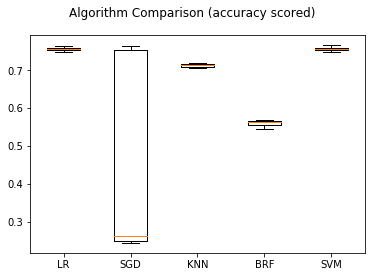

In [830]:
#Box plot of accuracy scores between algorithms
fig = plt.figure()
fig.suptitle('Algorithm Comparison (accuracy scored)')
ax = fig.add_subplot(111)
plt.boxplot(results_a)
ax.set_xticklabels(names)
plt.savefig('AlgCompAcc.png')
plt.show()

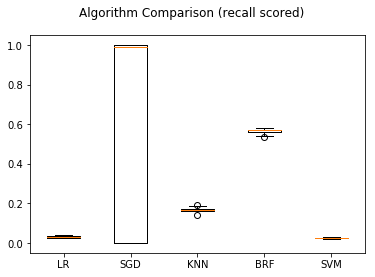

In [831]:
#Box plot of recall scores between algorithms
fig = plt.figure()
fig.suptitle('Algorithm Comparison (recall scored)')
ax = fig.add_subplot(111)
plt.boxplot(results_r)
ax.set_xticklabels(names)
plt.savefig('AlgCompRec.png')
plt.show()

*We can see by the results of the CV tests for each model that the Support Vector Machine and Logistic Regression performed the best in terms of accuracy. However, if we look at bothe recall and accuracy, Random Forest and SGD performed best. SVMs are complex and take a longer time to tune and the SGD here was subject to overfitting (evidenced by the high variance/high standard deviation. So either Logistic Regression or Random Forest would be best. The purpose of the question behind this is inspired by the idea that if authorities were able to better predict whether there was collateral damage and then respond in like with increased assistance on sight etc. In this system False Negatives (situations where the incident did have collateral but the model predicts it doesn't) would be more important and therefor recall should be the main score we should try and aim to maximize.*

In [799]:
#Preparing the chosen model for hyperperameter tuning
lr = BalancedRandomForestClassifier(n_jobs=3,
                                    random_state = 42)

In [814]:
#These parameters were chosen because other parameters would not make much of a difference in the score
param_grid = {'criterion':('gini','entropy'),
              'max_features': ('auto','log2')}

In [815]:
#Initializing the cross validated gridsearch over the different parameters
gs = GridSearchCV(estimator = lr, param_grid = param_grid, 
                  scoring = {'accuracy', 'recall'},
                  n_jobs = 3, 
                  cv = 10,
                  refit='recall',
                  verbose = 2)

In [816]:
#Fitting the gridsearch
gs.fit(X_train,y_train)

Fitting 10 folds for each of 4 candidates, totalling 40 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  35 tasks      | elapsed:  1.0min
[Parallel(n_jobs=3)]: Done  40 out of  40 | elapsed:  1.2min finished


GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=BalancedRandomForestClassifier(bootstrap=True, class_weight=None,
                criterion='gini', max_depth=None, max_features='auto',
                max_leaf_nodes=None, min_impurity_decrease=0.0,
                min_samples_leaf=2, min_samples_split=2,
                min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=3,
                oob_score=False, random_state=42, replacement=False,
                sampling_strategy='auto', verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=3,
       param_grid={'criterion': ('gini', 'entropy'), 'max_features': ('auto', 'log2')},
       pre_dispatch='2*n_jobs', refit='recall', return_train_score='warn',
       scoring={'accuracy', 'recall'}, verbose=2)

In [817]:
#taking a look at the best paramaters by score
gs.best_params_

{'criterion': 'gini', 'max_features': 'auto'}

In [819]:
#Setting the output of the gridsearch to a 'final_pred' variable to verify the strength of the model
final_pred = gs.best_estimator_

In [820]:
#Entering test data
y_pred = final_pred.predict(X_test)

In [821]:
#Generating Confusion matrix
tn, fp, fn, tp = confusion_matrix(y_test,y_pred).ravel()

In [822]:
confusion_matrix(y_test,y_pred).ravel()

array([4927, 3900, 1275, 1699])

In [826]:
df_cm = pd.DataFrame()
df_cm['Predicted Positive'] = [fp,tp]
df_cm['Predicted Negative'] = [tn,fn]
df_cm.index = ['True Negative','True Positive']

In [827]:
df_cm

,Predicted Positive,Predicted Negative
True Negative,3900,4927
True Positive,1699,1275


The confusion matrix above proves our hyothesis somehwat wrong. Although the model does predict the possibility of a 2nd harmful event occurring, it does so with fairly low accuracy. The model has a large amount of false positives because recall was chosen as the metric to focus on. But even so, there are still a lot of false negatives, which makes the model not useful. The point of the model is to try and predict when authorities need to employ extra resources to a crash based on the time and place because of the existence of a secondary harmful event. This model would not perform well in the real world and needs more features in training to be useful.

In [841]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

In [848]:
y = label_binarize(y, classes=[0,1])
n_classes = y.shape[1]
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    print(i)
    fpr[i], tpr[i] = roc_curve(y_test[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

0


TypeError: list indices must be integers or slices, not tuple